In [35]:
# Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [36]:
# Loading  Data

df = pd.read_excel('/Users/apple/Downloads/Imperial/Betting Comp/data/train__1_.xlsx')
df.dropna(inplace=True)
df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1
1,2827,793,2005-04-02,338,597,3.0,2.0,3,6
2,2828,793,2005-04-02,1364,246,2.0,3.0,13,2
3,2829,793,2005-04-02,1088,1397,1.0,0.0,2,5
4,2830,793,2005-04-02,830,1412,2.0,3.0,3,6


In [37]:
# Computing Total Corners

df['Total_Corners'] = df['Home_Corners'] + df['Away_Corners']

In [38]:
## Including the average corners per team

home_avg_corners = df.groupby('HomeTeamId')['Home_Corners'].mean().rename('Home_Avg_Corners')
away_avg_corners = df.groupby('AwayTeamId')['Away_Corners'].mean().rename('Away_Avg_Corners')


df = df.merge(home_avg_corners, left_on='HomeTeamId', right_index=True, how='left')
df = df.merge(away_avg_corners, left_on='AwayTeamId', right_index=True, how='left')

In [39]:
# Including the average corners conceded per team

home_corners_conceded = df.groupby('HomeTeamId')['Away_Corners'].mean().rename('Home_Avg_Corners_Conceded')
away_corners_conceded = df.groupby('AwayTeamId')['Home_Corners'].mean().rename('Away_Avg_Corners_Conceded')

df = df.merge(home_corners_conceded, left_on='HomeTeamId', right_index=True, how='left')
df = df.merge(away_corners_conceded, left_on='AwayTeamId', right_index=True, how='left')

In [40]:
# Introducing 3-game averages corner statistics

df['3_Game_Home_Conceded_Avg'] = df.groupby('HomeTeamId')['Away_Corners'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['3_Game_Away_Conceded_Avg'] = df.groupby('AwayTeamId')['Home_Corners'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())

df['3_Game_Home_Avg'] = df.groupby('HomeTeamId')['Home_Corners'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['3_Game_Away_Avg'] = df.groupby('AwayTeamId')['Away_Corners'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())


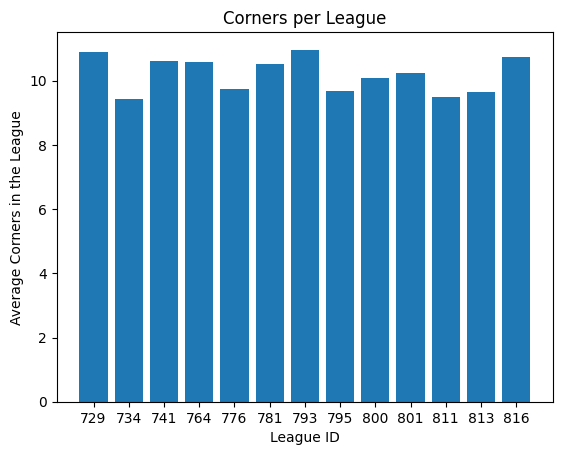

In [41]:
# Exploring the League corner dynamics/differences

league_corners_avg = df.groupby(by = ['LeagueId'])['Total_Corners'].mean()
plt.bar(x = league_corners_avg.index.astype('str'), height = league_corners_avg)
plt.xlabel('League ID')
plt.ylabel('Average Corners in the League')
plt.title('Corners per League')

plt.savefig(f"league_corners.png", format='png', dpi=300, bbox_inches="tight")

df = df.merge(pd.get_dummies(df['LeagueId']), left_index=True, right_index=True)

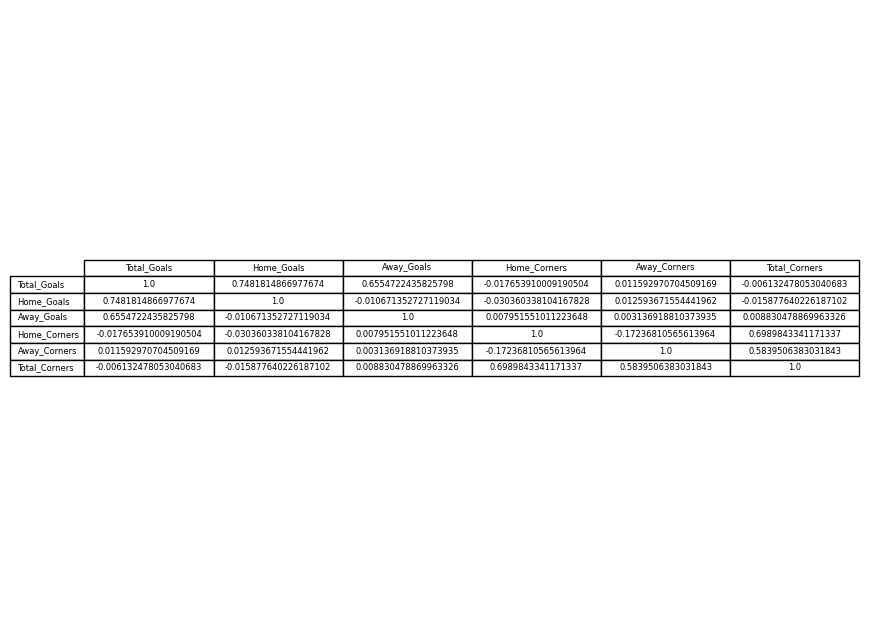

In [42]:
# Exploring  the correlation between goals scores and corners obtained/conceded

df['Total_Goals'] = df['Home_Goals'] + df['Away_Goals']
corr_df = df[['Total_Goals', 'Home_Goals', 'Away_Goals', 'Home_Corners', 'Away_Corners', 'Total_Corners']].corr()

fig, ax = plt.subplots(figsize=(10,8)) 
ax.axis('off')

perf_table = ax.table(cellText=corr_df.values, colLabels=corr_df.columns, rowLabels = corr_df.index, cellLoc='center', loc='center', fontsize=20)
plt.savefig("corr_table.png", dpi=100)

In [43]:
# Tetsing Poisson distribution Hypothesis on total corners

tot_corners_avg = np.mean(df['Total_Corners'])
tot_corners_var = np.var(df['Total_Corners'])

r = tot_corners_avg**2/ (tot_corners_var-tot_corners_avg)
p = tot_corners_avg /tot_corners_var

dispersion = 1/p
print(f"Mean: {tot_corners_avg:.3f}, Variance: {tot_corners_var:.3f}, Dispersion: {dispersion:.3f}")

if dispersion > 1.5:  # Heuristic threshold
    print("Evidence of overdispersion: Poisson model may not be appropriate.")
else:
    print("No significant overdispersion detected: Poisson model may be appropriate.")


Mean: 10.219, Variance: 11.908, Dispersion: 1.165
No significant overdispersion detected: Poisson model may be appropriate.


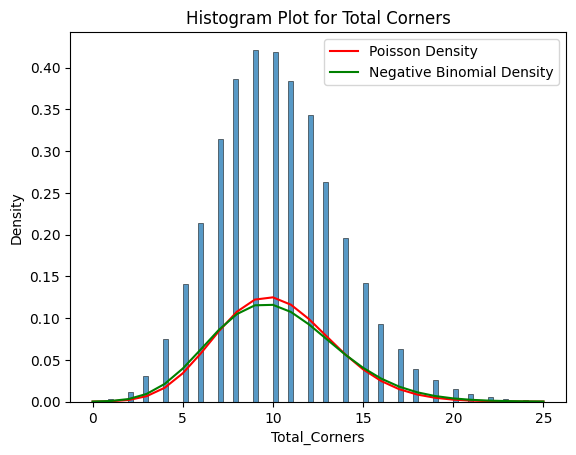

In [44]:
# Visual fit of the Poisson distibrution

sns.histplot(df['Total_Corners'], stat = 'density')
x = np.arange(0, df['Total_Corners'].max() + 1)
y = stats.poisson.pmf(x, tot_corners_avg)
z = stats.nbinom.pmf(x, r, p)
plt.plot(x, y, linestyle='-', color = 'red', label = 'Poisson Density')
plt.plot(x, z, linestyle='-', color = 'green', label = 'Negative Binomial Density')
plt.legend()
plt.title('Histogram Plot for Total Corners')

plt.savefig(f"fitted_distrib.png", format='png', dpi=300, bbox_inches="tight")


In [45]:
# Preparing clean Training Data Data

df_clean = df[['HomeTeamId', 'AwayTeamId', 'LeagueId', 'Home_Avg_Corners', 'Away_Avg_Corners', 'Home_Avg_Corners_Conceded', 'Away_Avg_Corners_Conceded',
               '3_Game_Home_Conceded_Avg',  '3_Game_Away_Conceded_Avg', '3_Game_Home_Avg', '3_Game_Away_Avg', 'Total_Corners']]
df_clean = df_clean.merge(pd.get_dummies(df_clean['LeagueId']), left_index=True, right_index=True).dropna()

In [46]:
# Separating Training data into training  and validation sets

np.random.seed(101)
df_train, df_val = train_test_split(df_clean, test_size=0.2)

df_train_target = df_train['Total_Corners']
df_train_inputs= df_train.drop(columns=['LeagueId', 'Total_Corners'])

df_val_target = df_val['Total_Corners']
df_val_inputs = df_val.drop(columns=['LeagueId', 'Total_Corners'])

In [47]:
# Preparing Test Data

df_test = pd.read_excel('/Users/apple/Downloads/Imperial/Betting Comp/data/test__1_.xlsx')

relevant_cols = ['HomeTeamId', 'AwayTeamId', 'Home_Avg_Corners', 'Away_Avg_Corners',
                 'Home_Avg_Corners_Conceded', 'Away_Avg_Corners_Conceded',
                 '3_Game_Home_Conceded_Avg', '3_Game_Away_Conceded_Avg',
                 '3_Game_Home_Avg', '3_Game_Away_Avg']

train_df = df_clean.sort_index()

last_home_stats = train_df.groupby('HomeTeamId').last()[['Home_Avg_Corners', 'Home_Avg_Corners_Conceded', '3_Game_Home_Avg', '3_Game_Home_Conceded_Avg']]
last_away_stats = train_df.groupby('AwayTeamId').last()[['Away_Avg_Corners', 'Away_Avg_Corners_Conceded', '3_Game_Away_Avg', '3_Game_Away_Conceded_Avg']]

df_test = df_test.merge(last_home_stats, left_on='HomeTeamId', right_index=True, how='left')
df_test = df_test.merge(last_away_stats, left_on='AwayTeamId', right_index=True, how='left')

df_test_inputs = df_test[df_clean.columns[:11]]
df_test_inputs = df_test_inputs.merge(pd.get_dummies(df_test_inputs['LeagueId']), left_index=True, right_index=True)

missing_cols = set(train_df.columns) - set(df_test_inputs.columns)
for col in missing_cols:
    df_test_inputs[col] = 0

df_test_inputs = df_test_inputs[train_df.columns].drop(columns = ["LeagueId", 'Total_Corners'])



In [48]:
# Saving Datasets

df_train_inputs.to_pickle("df_train_inputs.pkl")
df_train_target.to_pickle("df_train_target.pkl")

df_val_inputs.to_pickle("df_val_inputs.pkl")
df_val_target.to_pickle("df_val_target.pkl")

df_test_inputs.to_pickle("df_test_inputs.pkl")
df_test = pd.read_excel('/Users/apple/Downloads/Imperial/Betting Comp/data/test__1_.xlsx')
df_test.to_pickle("df_test.pkl")
